In [1]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump
import pyxdf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

Authorization classes are not loaded, using fake implementations.


In [2]:
# Combine all data stored in the same folder to use for training the model.
def concat_data(frequency):
    data_folder = f'../../../../data_ssvep/Toey/SSVEP_data/{frequency}/'
    all_data = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        streams, _ = pyxdf.load_xdf(file_path)
        raw_data = streams[0]["time_series"].T
        all_data.append(raw_data)
    all_data_array = np.concatenate(all_data, axis=1)
    return all_data_array


In [3]:
# The stored data will be kept for an average of 80 seconds, so the data will be cut into parts. set_size is the sample that you want per 1 set. overlap is how much data in each set will overlap.
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [4]:
name_data = 'youtube'
raw_data1 = concat_data('6Hz')
print(raw_data1.shape)
raw_data2 = concat_data('20Hz')
print(raw_data2.shape)
raw_data3 = concat_data('0Hz')
print(raw_data3.shape)

(8, 144520)
(8, 164360)
(8, 137610)


In [5]:
# Store data in only 4 channels: Oz Pz O1 O2
data1 = raw_data1[0:4,:]
data2 = raw_data2[0:4,:]
data3 = raw_data3[0:4,:]
print(data1.shape)
print(data2.shape)
print(data3.shape)

(4, 144520)
(4, 164360)
(4, 137610)


In [6]:
# Adjust the reference using Pz as the channel ref.
data1_oz = data1[0] - data1[1]
data1_o1 = data1[2] - data1[1]
data1_o2 = data1[3] - data1[1]

data2_oz = data2[0] - data2[1]
data2_o1 = data2[2] - data2[1]
data2_o2 = data2[3] - data2[1]

data3_oz = data3[0] - data3[1]
data3_o1 = data3[2] - data3[1]
data3_o2 = data3[3] - data3[1]

print(data1_oz.shape, data1_o1.shape, data1_o2.shape)
print(data2_oz.shape, data2_o1.shape, data2_o2.shape)
print(data3_oz.shape, data3_o1.shape, data3_o2.shape)

(144520,) (144520,) (144520,)
(164360,) (164360,) (164360,)
(137610,) (137610,) (137610,)


In [7]:
# The number seen is the number of members in the list, each member containing 1000 samples.
data1_set_oz = create_overlapping_sets(data1_oz, set_size=1000, overlap_fraction=0.5)
data1_set_o1 = create_overlapping_sets(data1_o1, set_size=1000, overlap_fraction=0.5)
data1_set_o2 = create_overlapping_sets(data1_o2, set_size=1000, overlap_fraction=0.5)

data2_set_oz = create_overlapping_sets(data2_oz, set_size=1000, overlap_fraction=0.5)
data2_set_o1 = create_overlapping_sets(data2_o1, set_size=1000, overlap_fraction=0.5)
data2_set_o2 = create_overlapping_sets(data2_o2, set_size=1000, overlap_fraction=0.5)

data3_set_oz = create_overlapping_sets(data3_oz, set_size=1000, overlap_fraction=0.5)
data3_set_o1 = create_overlapping_sets(data3_o1, set_size=1000, overlap_fraction=0.5)
data3_set_o2 = create_overlapping_sets(data3_o2, set_size=1000, overlap_fraction=0.5)

In [8]:
print(len(data1_set_oz), len(data1_set_o1), len(data1_set_o2))
print(len(data2_set_oz), len(data2_set_o1), len(data2_set_o2))
print(len(data3_set_oz), len(data3_set_o1), len(data3_set_o2))

288 288 288
327 327 327
274 274 274


In [9]:
import numpy as np
from scipy.signal import welch, find_peaks, butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Define function to calculate PSD
def calculate_psd(data, fs=250, nperseg=250*4):
    f, Pxx = welch(data, fs=fs, nperseg=nperseg)
    return f, Pxx

# Define function to detect peaks
def detect_peaks(Pxx):
    peaks, _ = find_peaks(Pxx)
    return peaks

# Define function for band-pass filtering
def band_pass_filter(data, lowcut, highcut, fs=250, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply band-pass filter and calculate PSD for each dataset
def process_data(data_set):
    filtered_data = [band_pass_filter(epoch, 0.5, 50) for epoch in data_set]
    data_fft = []
    for epoch in filtered_data:
        f, Pxx = calculate_psd(epoch)
        peaks = detect_peaks(Pxx)
        data_fft.append(Pxx[:121])
    return data_fft

In [10]:
# Process each dataset
data1_fft_oz = process_data(data1_set_oz)
data1_fft_o1 = process_data(data1_set_o1)
data1_fft_o2 = process_data(data1_set_o2)

data2_fft_oz = process_data(data2_set_oz)
data2_fft_o1 = process_data(data2_set_o1)
data2_fft_o2 = process_data(data2_set_o2)

data3_fft_oz = process_data(data3_set_oz)
data3_fft_o1 = process_data(data3_set_o1)
data3_fft_o2 = process_data(data3_set_o2)

# Combine the data
combined_data1 = np.hstack((data1_fft_oz, data1_fft_o1, data1_fft_o2))
combined_data2 = np.hstack((data2_fft_oz, data2_fft_o1, data2_fft_o2))
combined_data3 = np.hstack((data3_fft_oz, data3_fft_o1, data3_fft_o2))

# Combine all data
combined_data = np.vstack((combined_data1, combined_data2, combined_data3))

# Create labels for each class
labels = np.array([0]*len(data1_fft_oz) + [1]*len(data2_fft_oz) + [2]*len(data3_fft_oz))

# Check that the combined data and labels have the correct shape
print(f"Combined data shape: {combined_data.shape}")
print(f"Labels shape: {labels.shape}")

Combined data shape: (889, 363)
Labels shape: (889,)


In [11]:
# Canonical Correlation Analysis (CCA)
cca = CCA(n_components=1)  
combined_data_cca = cca.fit_transform(combined_data, labels)

# For each array in the tuple, access and perform a flat transformation.
combined_data_flat = np.hstack([arr.reshape(-1, 1) for arr in combined_data_cca])

dump(cca, f'model_P_CCA/cca_model_ml_{name_data}.joblib')

# Features Normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(combined_data_flat)

# Features Classification using Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_normalized, labels, test_size=0.2, random_state=42)

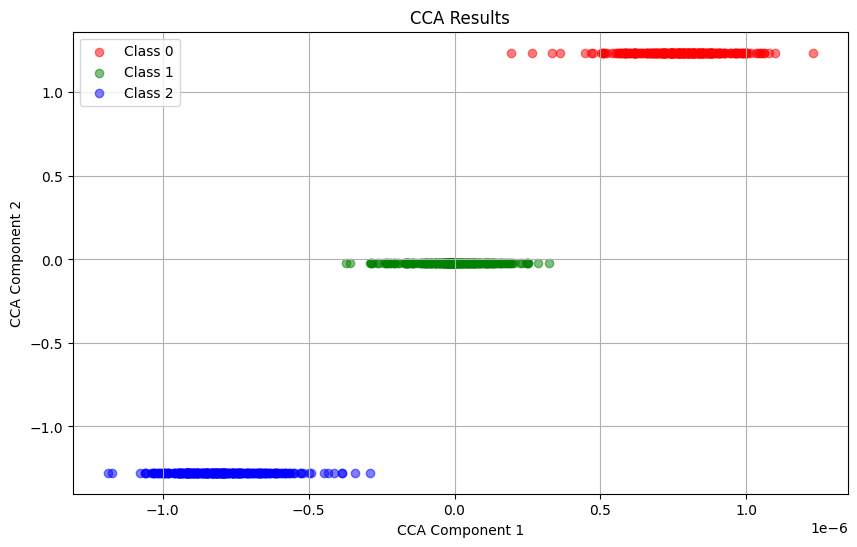

In [12]:
plt.figure(figsize=(10, 6))

# Assuming labels are provided as an array with the same length as the data
classes = np.unique(labels)
colors = ['r', 'g', 'b']  # Assigning a color for each class

for i, cls in enumerate(classes):
    plt.scatter(combined_data_flat[labels == cls, 0], combined_data_flat[labels == cls, 1], 
                color=colors[i], label=f'Class {cls}', alpha=0.5)

plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Results')
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best accuracy on test set: 1.0
                                               params  mean_test_score  \
0   {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.998592   
1   {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.998592   
2   {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.997183   
3   {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.998592   
4   {'max_depth': None, 'min_samples_leaf': 1, 'mi...         0.998592   
..                                                ...              ...   
76  {'max_depth': 20, 'min_samples_leaf': 4, 'min_...         0.998592   
77  {'max_depth': 20, 'min_samples_leaf': 4, 'min_...         0.994366   
78  {'max_depth': 20, 'min_samples_leaf': 4, 'min_...         0.998592   
79  {'max_depth': 20, 'min_samples_leaf': 4, 'min_..

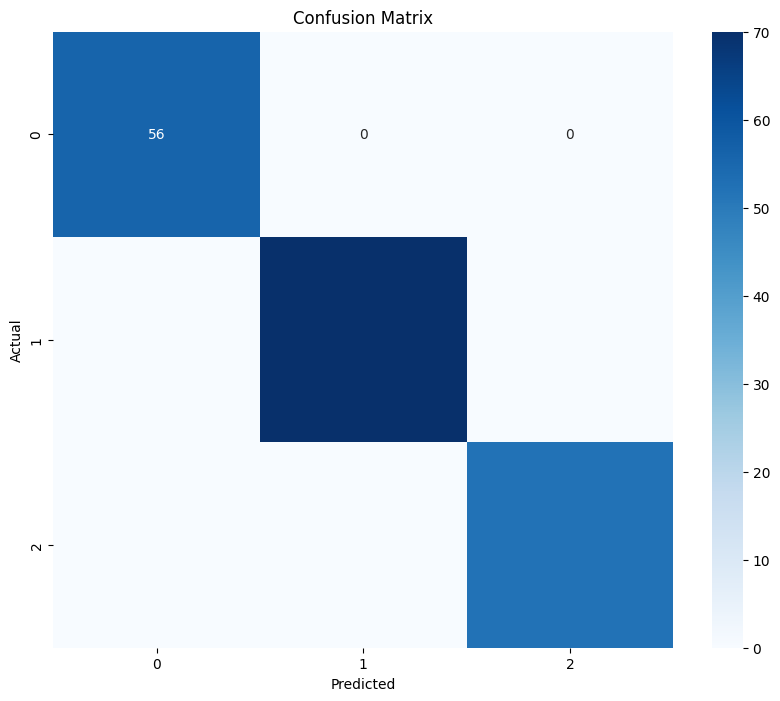

In [13]:
# Set the values of the hyperparameters that we are interested in
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV model to data
grid_search.fit(X_train, y_train)

# Show the best hyperparameters
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Predict on test set using the best model from Grid Search.
best_rf_classifier = grid_search.best_estimator_
y_pred_best = best_rf_classifier.predict(X_test)

dump(best_rf_classifier, f'model_P_CCA/best_rf_classifier_{name_data}.joblib')

# Calculate average accuracy
best_accuracy = accuracy_score(y_test, y_pred_best)
print("Best accuracy on test set:", best_accuracy)

# Create a DataFrame to display the results of Grid Search.
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# Calculate precision, recall, F1-score, and accuracy per class
precision_per_class = precision_score(y_test, y_pred_best, average=None)
recall_per_class = recall_score(y_test, y_pred_best, average=None)
f1_per_class = f1_score(y_test, y_pred_best, average=None)

# Calculate accuracy per class
accuracy_per_class = []
for class_label in range(len(precision_per_class)):
    correct_predictions = ((y_pred_best == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_best == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_per_class.append(accuracy)

# Calculate average precision, recall, F1-score, and accuracy
avg_precision = precision_score(y_test, y_pred_best, average='weighted')
avg_recall = recall_score(y_test, y_pred_best, average='weighted')
avg_f1 = f1_score(y_test, y_pred_best, average='weighted')

# Create DataFrame for per-class metrics
results_per_class_df = pd.DataFrame({
    'Class': range(len(precision_per_class)),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-score': f1_per_class,
    'Accuracy': accuracy_per_class
})

# Add average metrics to the DataFrame
results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, best_accuracy]

print(results_per_class_df)

# Create Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters found:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best accuracy on test set: 1.0
                                               params  mean_test_score  \
0    {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}         1.000000   
1      {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}         0.998592   
2       {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}         1.000000   
3   {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}         1.000000   
4     {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}         1.000000   
5       {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}         0.998592   
6        {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}         1.000000   
7    {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}         1.000000   
8      {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}         1.000000   
9        {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}         1.000000   
10        {'C': 

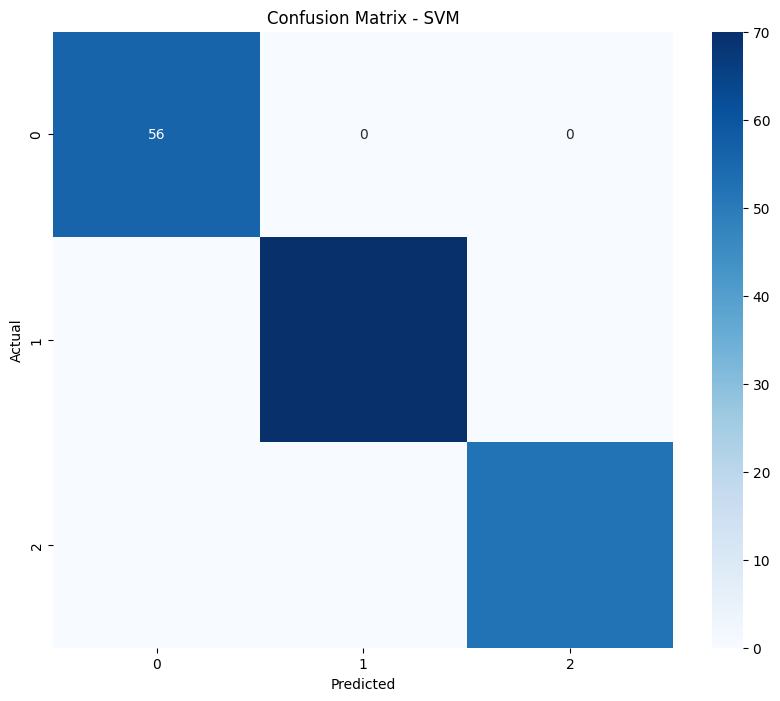

In [14]:
# Set the values of the hyperparameters that we are interested in
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Create SVM Classifier
svm_classifier = SVC()

# Create GridSearchCV object
grid_search_svm = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV model to data
grid_search_svm.fit(X_train, y_train)

# Show the best hyperparameters
print("Best hyperparameters found:")
print(grid_search_svm.best_params_)

# Predict on test set using the best model from Grid Search
best_svm_classifier = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm_classifier.predict(X_test)

# Calculate average accuracy
best_accuracy_svm = accuracy_score(y_test, y_pred_best_svm)
print("Best accuracy on test set:", best_accuracy_svm)

# Save the best SVM classifier model
dump(best_svm_classifier, f'model_P_CCA/best_svm_classifier_{name_data}.joblib')

# Create a DataFrame to display the results of Grid Search
results_df_svm = pd.DataFrame(grid_search_svm.cv_results_)
print(results_df_svm[['params', 'mean_test_score', 'std_test_score']])

# Calculate precision, recall, F1-score, and accuracy per class
precision_per_class_svm = precision_score(y_test, y_pred_best_svm, average=None)
recall_per_class_svm = recall_score(y_test, y_pred_best_svm, average=None)
f1_per_class_svm = f1_score(y_test, y_pred_best_svm, average=None)

# Calculate accuracy per class
accuracy_per_class_svm = []
for class_label in range(len(precision_per_class_svm)):
    correct_predictions = ((y_pred_best_svm == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_best_svm == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_per_class_svm.append(accuracy)

# Calculate average precision, recall, F1-score, and accuracy
avg_precision_svm = precision_score(y_test, y_pred_best_svm, average='weighted')
avg_recall_svm = recall_score(y_test, y_pred_best_svm, average='weighted')
avg_f1_svm = f1_score(y_test, y_pred_best_svm, average='weighted')

# Create DataFrame for per-class metrics
results_per_class_df_svm = pd.DataFrame({
    'Class': range(len(precision_per_class_svm)),
    'Precision': precision_per_class_svm,
    'Recall': recall_per_class_svm,
    'F1-score': f1_per_class_svm,
    'Accuracy': accuracy_per_class_svm
})

# Add average metrics to the DataFrame
results_per_class_df_svm.loc['average'] = [None, avg_precision_svm, avg_recall_svm, avg_f1_svm, best_accuracy_svm]

print(results_per_class_df_svm)

# Create Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters found:
{'shrinkage': None, 'solver': 'svd'}
Best accuracy on test set: 1.0
                                     params  mean_test_score  std_test_score
0      {'shrinkage': None, 'solver': 'svd'}         1.000000        0.000000
1     {'shrinkage': None, 'solver': 'lsqr'}         0.991549        0.008213
2    {'shrinkage': None, 'solver': 'eigen'}         1.000000        0.000000
3    {'shrinkage': 'auto', 'solver': 'svd'}              NaN             NaN
4   {'shrinkage': 'auto', 'solver': 'lsqr'}         1.000000        0.000000
5  {'shrinkage': 'auto', 'solver': 'eigen'}         1.000000        0.000000
         Class  Precision  Recall  F1-score  Accuracy
0          0.0        1.0     1.0       1.0       1.0
1          1.0        1.0     1.0       1.0       1.0
2          2.0        1.0     1.0       1.0       1.0
average    NaN        1.0     1.0       1.0       1.0


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Toey\AppData\Roaming\Python\Python311\site-package

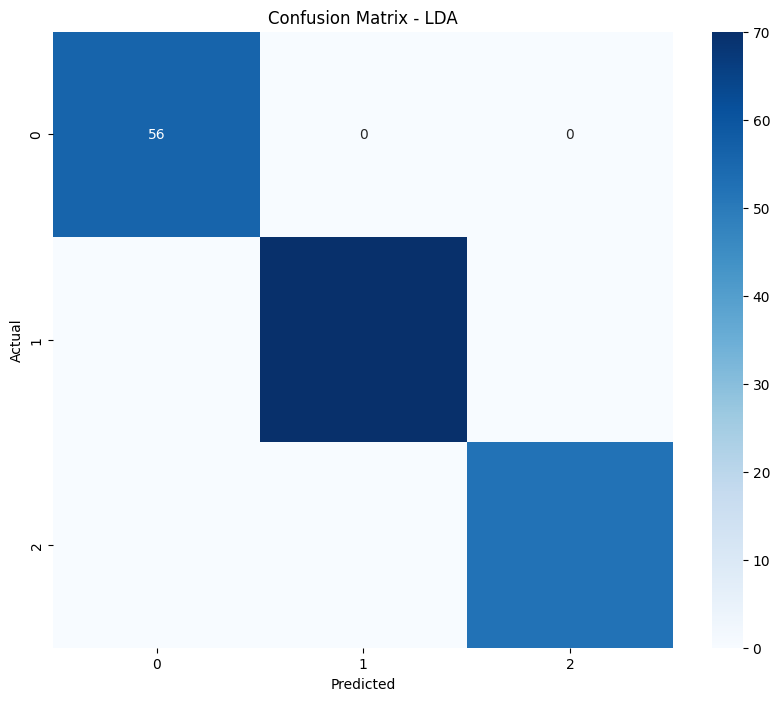

In [15]:
# Set the values of the hyperparameters that we are interested in
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto']
}

# Create LDA Classifier
lda_classifier = LinearDiscriminantAnalysis()

# Create GridSearchCV object
grid_search_lda = GridSearchCV(estimator=lda_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV model to data
grid_search_lda.fit(X_train, y_train)

# Show the best hyperparameters
print("Best hyperparameters found:")
print(grid_search_lda.best_params_)

# Predict on test set using the best model from Grid Search
best_lda_classifier = grid_search_lda.best_estimator_
y_pred_best_lda = best_lda_classifier.predict(X_test)

# Calculate average accuracy
best_accuracy_lda = accuracy_score(y_test, y_pred_best_lda)
print("Best accuracy on test set:", best_accuracy_lda)

# Save the best LDA classifier model
dump(best_lda_classifier, f'model_P_CCA/best_lda_classifier_{name_data}.joblib')

# Create a DataFrame to display the results of Grid Search
results_df_lda = pd.DataFrame(grid_search_lda.cv_results_)
print(results_df_lda[['params', 'mean_test_score', 'std_test_score']])

# Calculate precision, recall, F1-score, and accuracy per class
precision_per_class_lda = precision_score(y_test, y_pred_best_lda, average=None)
recall_per_class_lda = recall_score(y_test, y_pred_best_lda, average=None)
f1_per_class_lda = f1_score(y_test, y_pred_best_lda, average=None)

# Calculate accuracy per class
accuracy_per_class_lda = []
for class_label in range(len(precision_per_class_lda)):
    correct_predictions = ((y_pred_best_lda == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_best_lda == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_per_class_lda.append(accuracy)

# Calculate average precision, recall, F1-score, and accuracy
avg_precision_lda = precision_score(y_test, y_pred_best_lda, average='weighted')
avg_recall_lda = recall_score(y_test, y_pred_best_lda, average='weighted')
avg_f1_lda = f1_score(y_test, y_pred_best_lda, average='weighted')

# Create DataFrame for per-class metrics
results_per_class_df_lda = pd.DataFrame({
    'Class': range(len(precision_per_class_lda)),
    'Precision': precision_per_class_lda,
    'Recall': recall_per_class_lda,
    'F1-score': f1_per_class_lda,
    'Accuracy': accuracy_per_class_lda
})

# Add average metrics to the DataFrame
results_per_class_df_lda.loc['average'] = [None, avg_precision_lda, avg_recall_lda, avg_f1_lda, best_accuracy_lda]

print(results_per_class_df_lda)

# Create Confusion Matrix
conf_matrix_lda = confusion_matrix(y_test, y_pred_best_lda)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lda, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LDA')
plt.show()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters found:
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best accuracy on test set: 1.0
                                               params  mean_test_score  \
0   {'metric': 'euclidean', 'n_neighbors': 3, 'wei...              1.0   
1   {'metric': 'euclidean', 'n_neighbors': 3, 'wei...              1.0   
2   {'metric': 'euclidean', 'n_neighbors': 5, 'wei...              1.0   
3   {'metric': 'euclidean', 'n_neighbors': 5, 'wei...              1.0   
4   {'metric': 'euclidean', 'n_neighbors': 7, 'wei...              1.0   
5   {'metric': 'euclidean', 'n_neighbors': 7, 'wei...              1.0   
6   {'metric': 'euclidean', 'n_neighbors': 9, 'wei...              1.0   
7   {'metric': 'euclidean', 'n_neighbors': 9, 'wei...              1.0   
8   {'metric': 'euclidean', 'n_neighbors': 10, 'we...              1.0   
9   {'metric': 'euclidean', 'n_neighbors': 10, 'we...              1.0   
1

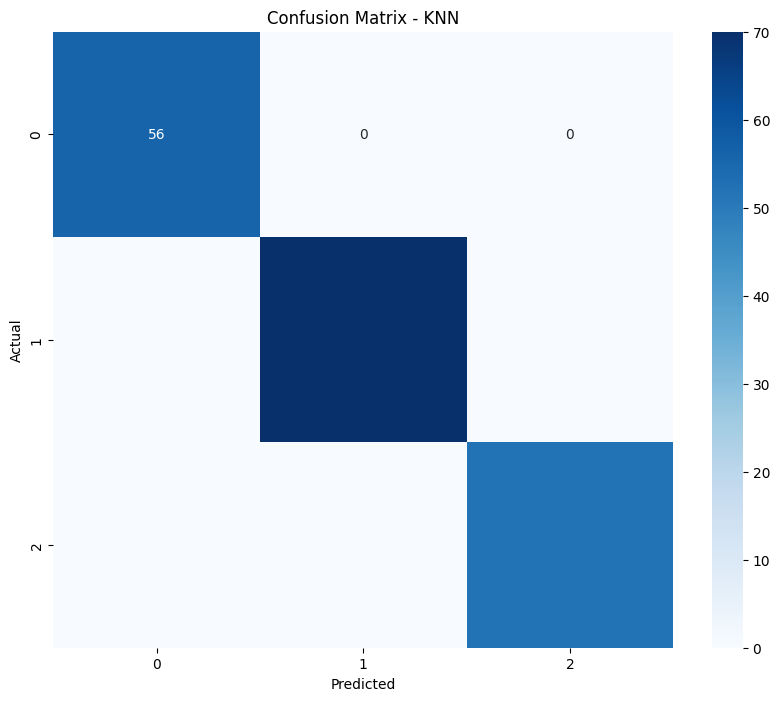

In [16]:
# Set the values of the hyperparameters that we are interested in
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create KNN Classifier
knn_classifier = KNeighborsClassifier()

# Create GridSearchCV object
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV model to data
grid_search_knn.fit(X_train, y_train)

# Show the best hyperparameters
print("Best hyperparameters found:")
print(grid_search_knn.best_params_)

# Predict on test set using the best model from Grid Search
best_knn_classifier = grid_search_knn.best_estimator_
y_pred_best_knn = best_knn_classifier.predict(X_test)

# Calculate average accuracy
best_accuracy_knn = accuracy_score(y_test, y_pred_best_knn)
print("Best accuracy on test set:", best_accuracy_knn)

# Save the best KNN classifier model
dump(best_knn_classifier, f'model_P_CCA/best_knn_classifier_{name_data}.joblib')

# Create a DataFrame to display the results of Grid Search
results_df_knn = pd.DataFrame(grid_search_knn.cv_results_)
print(results_df_knn[['params', 'mean_test_score', 'std_test_score']])

# Calculate precision, recall, F1-score, and accuracy per class
precision_per_class_knn = precision_score(y_test, y_pred_best_knn, average=None)
recall_per_class_knn = recall_score(y_test, y_pred_best_knn, average=None)
f1_per_class_knn = f1_score(y_test, y_pred_best_knn, average=None)

# Calculate accuracy per class
accuracy_per_class_knn = []
for class_label in range(len(precision_per_class_knn)):
    correct_predictions = ((y_pred_best_knn == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_best_knn == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_per_class_knn.append(accuracy)

# Calculate average precision, recall, F1-score, and accuracy
avg_precision_knn = precision_score(y_test, y_pred_best_knn, average='weighted')
avg_recall_knn = recall_score(y_test, y_pred_best_knn, average='weighted')
avg_f1_knn = f1_score(y_test, y_pred_best_knn, average='weighted')

# Create DataFrame for per-class metrics
results_per_class_df_knn = pd.DataFrame({
    'Class': range(len(precision_per_class_knn)),
    'Precision': precision_per_class_knn,
    'Recall': recall_per_class_knn,
    'F1-score': f1_per_class_knn,
    'Accuracy': accuracy_per_class_knn
})

# Add average metrics to the DataFrame
results_per_class_df_knn.loc['average'] = [None, avg_precision_knn, avg_recall_knn, avg_f1_knn, best_accuracy_knn]

print(results_per_class_df_knn)

# Create Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()